In [132]:
import os
from pickle import load
import matplotlib.pyplot as plt
from numpy import array, stack
import torch 
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn 
from torch import optim 
from torchsummary import summary

## Load precoder dataset

In [133]:
def load_dataset(dir_name, fading, num_ant, SNR_dB, bit_codebook):

    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    file_name = f'{dir_name}/{fading}_precoder_data_{num_ant}_ant_SNR_{SNR_dB}dB_{bit_codebook}_bit_codebk'
    print(file_name)
    with open(f'{file_name}.pkl', 'rb') as f:
        precoders, labels = load(f)
    return precoders, labels

## Visualization of Data

In [134]:
def visualize(precoders):
    # test plots
    for i in range(2):
        plt.scatter(precoders[i][0::2], precoders[i][1::2])
        plt.show()

## Precoder dataset class that packages the dataset into a format compatible with PyTorch

In [135]:
class PrecoderDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.data)

## Neural Network Class

In [136]:

class Model(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        # define layers and activation function as class parameters
        self.fc1 = nn.Linear(in_features=input_size, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=100)
        self.output = nn.Linear(in_features=100, out_features=output_size)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        # define NN connections here, output of last layer is pred
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        pred = self.softmax(self.output(x))
        return pred


## Essential System Parameters

In [137]:
max_iter = 100000
fading = 1
num_ant = [2, 4]
SNR_dB = [10, 20, 40]
bit_codebook = [1, 2]
visual = 0

## Training Parameters

In [138]:
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()
num_epochs = 5 # Number of times you go through the whole dataset

## Simulation iterations
1. Load dataset
2. Visualize, if necessary 
3. Create instance of precoder dataset class (Package dataset such that it is compatible for PyTorch)
4. Split dataset into 80% training and 20% validation
5. Create PyTorch dataloaders for training and validation data (Dataloaders divide the dataset into chuncks called batches. We can pass data to the neural network one batch at a time) 
6. Create an instance of neural network class
7. Define the loss and optimizer
8. Epoch - one pass of the entire dataset (training + validation)
9. In each epoch you iterate over several batches (Batch - chunk of data that is fed to the neural network in one go) 

10 dB, 2 antennas, 1 bit codebook
datasets/1_precoder_data_2_ant_SNR_10dB_1_bit_codebk


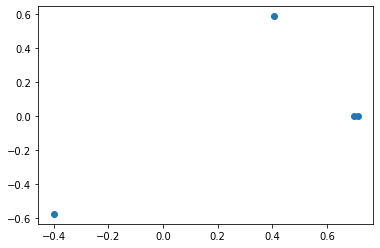

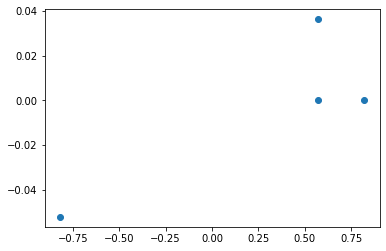

/home/utsa/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch 1, training loss: 0.69170070, training accuracy: 50.0225%, validation loss: 0.69178784, validation accuracy: 49.845%
Epoch 2, training loss: 0.69170064, training accuracy: 50.0225%, validation loss: 0.69176245, validation accuracy: 49.845%
Epoch 3, training loss: 0.69170064, training accuracy: 50.0225%, validation loss: 0.69177979, validation accuracy: 49.845%
Epoch 4, training loss: 0.69170070, training accuracy: 50.0225%, validation loss: 0.69177127, validation accuracy: 49.845%
Epoch 5, training loss: 0.69170070, training accuracy: 50.0225%, validation loss: 0.69175917, validation accuracy: 49.845%
10 dB, 2 antennas, 2 bit codebook
datasets/1_precoder_data_2_ant_SNR_10dB_2_bit_codebk


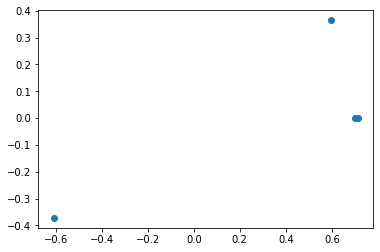

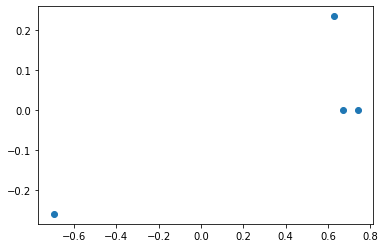

Epoch 1, training loss: 1.38911068, training accuracy: 25.035%, validation loss: 1.38900578, validation accuracy: 25.525%
Epoch 2, training loss: 1.38911057, training accuracy: 25.035%, validation loss: 1.38897741, validation accuracy: 25.525%
Epoch 3, training loss: 1.38911057, training accuracy: 25.035%, validation loss: 1.38900769, validation accuracy: 25.525%
Epoch 4, training loss: 1.38911068, training accuracy: 25.035%, validation loss: 1.38900280, validation accuracy: 25.525%
Epoch 5, training loss: 1.38911068, training accuracy: 25.035%, validation loss: 1.38897419, validation accuracy: 25.525%
10 dB, 4 antennas, 1 bit codebook
datasets/1_precoder_data_4_ant_SNR_10dB_1_bit_codebk


FileNotFoundError: [Errno 2] No such file or directory: 'datasets/1_precoder_data_4_ant_SNR_10dB_1_bit_codebk.pkl'

In [139]:
for SNR in SNR_dB:
    for ant in num_ant:
        for bit in bit_codebook:
            print(f'======{SNR} dB, {ant} antennas, {bit} bit codebook======')
            
            precoders, labels = load_dataset('datasets', fading, ant, SNR, bit)
            if visual == 1:
                visualize(precoders)

            precoder_data = stack(precoders, axis=0)
            precoder_labels = array(labels)    

            precoder_dataset = PrecoderDataset(precoder_data, precoder_labels)
            train, val = random_split(precoder_dataset, [int(0.8*max_iter), int(0.2*max_iter)])
            train_loader = DataLoader(train, batch_size=128, shuffle=True, num_workers=0)
            val_loader = DataLoader(val, batch_size=128, shuffle=True, num_workers=0)
            
            num_classes = 2**bit
            nn_input_size = 2*ant*ant
            nn_output_size = num_classes
            
            model = Model(nn_input_size, nn_output_size)

            if torch.cuda.is_available():
                model.cuda()

            
            for epoch in range(num_epochs):

                # TRAINING
                model.train()
                training_total_correct = 0
                training_losses = list()
                for batch in train_loader:

                    x, y = batch # extracted from the batch 

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    # step 1: forward pass 
                    prob = model(x) 

                    output = prob
                    target = y

                    # step 2: compute objective function - measuring distance between the output of the network vs actual answer 
                    obj_func = loss(output, target)

                    # step 3: clear the gradients 
                    model.zero_grad()

                    # step 4: accumulate partial derivatives of obj_func wrt parameters 
                    obj_func.backward()

                    # step 5: step in the opposite direction of the gradient 
                    optimizer.step()

                    training_losses.append(obj_func.item())

                    max_prob, max_ind = torch.max(output, 1)
                    for ind in range(len(max_ind)):
                        if torch.equal(max_ind[ind], y[ind]):
                            training_total_correct += 1    

                # VALIDATION
                model.eval()

                validation_total_correct = 0
                validation_losses = list()
                for batch in val_loader:

                    x, y = batch # extracted from the batch 

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    # step 1: forward pass 
                    with torch.no_grad():
                        prob = model(x) 

                    output = prob
                    target = y

                    # step 2: compute objective function - measuring distance between the output of the network vs actual answer 
                    obj_func = loss(output, target)
                    validation_losses.append(obj_func.item())

                    max_prob, max_ind = torch.max(output, 1)

                    for ind in range(len(max_ind)):
                        if torch.equal(max_ind[ind], y[ind]):
                            validation_total_correct += 1
                training_accuracy = (training_total_correct/len(train))*100  
                validation_accuracy = (validation_total_correct/len(val))*100   

                print(f'Epoch {epoch + 1}, training loss: {torch.tensor(training_losses).mean():.8f}, training accuracy: {training_accuracy}%, validation loss: {torch.tensor(validation_losses).mean():.8f}, validation accuracy: {validation_accuracy}%')